In [1]:
%%capture
%load_ext autoreload
%autoreload 2
%matplotlib inline
# %cd .. 
import sys
sys.path.append("..")
import statnlpbook.util as util
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
import random 
from collections import defaultdict
random.seed(2)

<!---
Latex Macros
-->
$$
\newcommand{\Xs}{\mathcal{X}}
\newcommand{\Ys}{\mathcal{Y}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\weights}{\mathbf{w}}
\newcommand{\balpha}{\boldsymbol{\alpha}}
\newcommand{\bbeta}{\boldsymbol{\beta}}
\newcommand{\aligns}{\mathbf{a}}
\newcommand{\align}{a}
\newcommand{\source}{\mathbf{s}}
\newcommand{\target}{\mathbf{t}}
\newcommand{\ssource}{s}
\newcommand{\starget}{t}
\newcommand{\repr}{\mathbf{f}}
\newcommand{\repry}{\mathbf{g}}
\newcommand{\bar}{\,|\,}
\newcommand{\x}{\mathbf{x}}
\newcommand{\prob}{p}
\newcommand{\Pulp}{\text{Pulp}}
\newcommand{\Fiction}{\text{Fiction}}
\newcommand{\PulpFiction}{\text{Pulp Fiction}}
\newcommand{\pnb}{\prob^{\text{NB}}}
\newcommand{\vocab}{V}
\newcommand{\params}{\boldsymbol{\theta}}
\newcommand{\param}{\theta}
\DeclareMathOperator{\perplexity}{PP}
\DeclareMathOperator{\argmax}{argmax}
\DeclareMathOperator{\argmin}{argmin}
\newcommand{\train}{\mathcal{D}}
\newcommand{\counts}[2]{\#_{#1}(#2) }
\newcommand{\length}[1]{\text{length}(#1) }
\newcommand{\indi}{\mathbb{I}}
$$

# Text Classification 

Automatically classify input text into a set of **atomic classes**

## Motivation
* **Information retrieval**: classify documents into topics, such as "sport" or "business"
* **Sentiment analysis**: classify tweets into being "positive" or "negative"  
* **Spam filters**: distinguish between "ham" and "spam"

<!-- TODO: Load Web Corpus, 4 Universities, something were Maxent works -->

## Text Classification as Structured Prediction
Simplest instance of [structured prediction](/template/statnlpbook/02_methods/00_structuredprediction) 

* Input space $\Xs$ are sequences of words
* output space $\Ys$ is a set of labels
    * $\Ys=\{ \text{sports},\text{business}\}$ in document classification
    * $\Ys=\{ \text{positive},\text{negative}, \text{neutral}\}$ in sentiment prediction
* model $s_{\params}(\x,y)$ 
    * scores $y$ highly if it fits text $\x$
    

## Overview

* **Generative** model: Naive Bayes
    * Learn how to *explain input and output*
* **Discriminative** model: *Logistic Regression*
    * Learn how to *discriminate best output based on input*

## Sentiment Analysis as Text Classification
Let us focus on a specific task: sentiment analysis

* load data for this task from the [Movie Review dataset](https://www.cs.cornell.edu/people/pabo/movie-review-data/)

In [2]:
from os import listdir
from os.path import isfile, join
def load_from_dir(directory,label):
    """
    Load documents from a directory, and give them all the same label `label`.
    Params:
        directory: the directory to load the documents from.
        label: the label to assign to each document.
    Returns:
        a list of (x,y) pairs where x is a tokenised document (list of words), and y is the label `label`.
    """
    result = []
    for file in listdir(directory):
        with open(directory + file, 'r') as f:
            text = f.read()
            tokens = [t.strip() for t in text.split()]
            result.append((tokens,label))
    return result
 
data_pos = load_from_dir('../data/rt-2k/txt_sentoken/pos/', 'pos') 
data_neg = load_from_dir('../data/rt-2k/txt_sentoken/neg/', 'neg')
    
data = data_pos + data_neg

Let us look at some example data ...

In [3]:
" ".join(data_neg[11][0][:200])

'janeane garofalo in a romantic comedy -- it was a good idea a couple years ago with the truth about cats and dogs but is almost excruciating in the matchmaker . this is a by-the-books movie that plods along on a predestined course with no surprises and very few laughs . it also jumps on the ever-popular political satire bandwagon and manages to fall flat there , too . garofalo plays a campaign aide to a massacusetts senator ( jay o . sanders ) running for reelection . denis leary plays the stereotypical strategist with no ethics who decides the only way for the scandal- plagued senator to win is to play up his irish roots and cash in on that boston roman catholic democrat contingent that\'s made the kennedy family so popular . so leary orders garofalo to go to ireland and dig up some relatives to exploit . she soon learns why " easier said than done " is the mantra of movies like this . the matchmaker falls for every cliche of things that can go wrong -- garofalo has to take a tiny pl

## Setup

Divide dataset in **train**, **test** and **development** set

In [4]:
random.seed(0)
shuffled = list(data)
random.shuffle(shuffled)
train, dev, test = shuffled[:1600], shuffled[1600:1800], shuffled[1800:]
len([(x,y) for (x,y) in train if y == 'pos']) # check balance

815

The simplest and most

## Naive Bayes Model

uses a distribution $p^{\mbox{NB}}_{\params}$ for $s_\params$:   

\begin{equation}
  s_{\params}(\x,\y)\ = p^{\text{NB}}_{\params}(\x,y)
\end{equation}

Naive Bayes is an instance of a 

### Noisy Channel Model

\begin{equation}
\prob^{\text{NB}}_{\params}(\x,y)= p^\text{NB}_{\params}(y) p^{\text{NB}}_{\params}(\x|y) 
\end{equation}

### Why Naive?

Makes a naive conditional independence assumption

\begin{equation}
  p^{\text{NB}}_{\params}(\x|y) = 
  \prod_i^{\text{length}(\x)} p^{\text{NB}}_{\params}(x_i|y)
\end{equation}

observed words are independent of each other
* when *conditioned on the label* $y$ 

For example:

$$
p^{\text{NB}}_{\params}(\text{great,tremendous}\bar+) = p^{\text{NB}}_{\params}(\text{great}\bar+)  p^{\text{NB}}_{\params}(\text{tremendous}\bar+)
$$

* Sometimes this is (approximately) true! 
* Even when it isn't NB may still work...


### Parametrization
The NB model has the parameters $\params=(\balpha,\bbeta)$ where 

\begin{split}
  p^{\text{NB}}_{\params}(w|y) & = \alpha_{w,y} \\\\
  p^{\text{NB}}_{\params}(y) & = \beta_{y}.
\end{split}

* $\balpha$ for per-class feature probabilities
* $\bbeta$ for class priors 

### Training Naive Bayes 

Maximum Likelihood estimation: 

\begin{split}
  \alpha_{w,y} & = \frac{\counts{\train}{w,y}}{\sum_{w'}\counts{\train}{w',y}}\\\\
  \beta_{y} & = \frac{\counts{\train}{y}}{\left| \train \right|}
\end{split}

MLE can produce zero probabilities for unseen events in two ways:

* Words in the training set, unseen for specific class
    * address via [Laplace Smoothing](language_models.ipynb) 
* Words outside of the training set
    * address later ...

### Laplace Smoothing

Let $V$ be the full training set vocabulary, and $\gamma$ a pseudo-count, then

\begin{split}
  \alpha^\gamma_{w,y} & = \frac{\counts{\train}{w,y} + \gamma}{|V|\gamma + \sum_{w'}\counts{\train}{w',y}}\\\\
\end{split}

In [5]:
def train_nb(data, pseudo_count=0.0):
    alpha = defaultdict(float)
    beta = defaultdict(float)
    vocab = set(w for x,_ in data for w in x)
    labels = set(y for _,y in data)
    norm = 0
    for x,y in data:
        for w in x:
            beta[y] += 1.0
            alpha[w,y] += 1
            norm += 1
    for y in labels:
        for w in vocab:
            alpha[w,y] = (alpha[w,y]+pseudo_count) / (beta[y] + len(vocab) * pseudo_count)

    for y in list(beta.keys()):
        beta[y] = beta[y] / norm
    return (alpha, beta)

Train NB on data:

In [6]:
theta = (alpha, beta) = train_nb(train)

**Inspect** the learned parameters of the NB model!  

* they are easy to interpret

The class prior $\bbeta$ looks sensible:

In [7]:
beta

defaultdict(float, {'neg': 0.46489673848425617, 'pos': 0.5351032615157438})

The per-class word distributions $\balpha$:

In [8]:
def plot_top_k(alpha, label='pos', k=10):
    positive_words = [w for (w,y) in alpha.keys() if y == label]
    sorted_positive_words = sorted(positive_words, key=lambda w:-alpha[w,label])[:k]
    util.plot_bar_graph([alpha[w,label] for w in sorted_positive_words],sorted_positive_words,rotation=45)

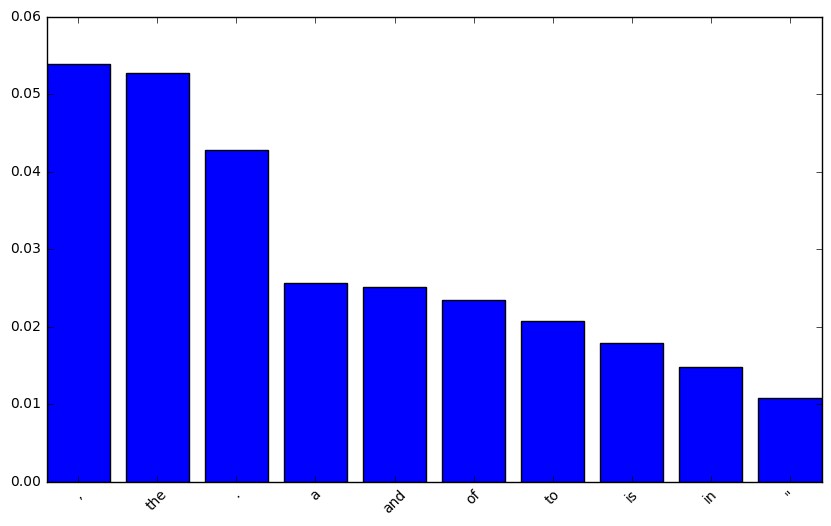

In [9]:
plot_top_k(alpha, 'pos')

Fairly uninformative! For most words 

* Clearly *any* document will contain these words with high probability
* Don't **discriminate** between document classes 

Remove such words apriori, using a so-called **stop-word** list

In [10]:
import string

stop_words = set(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', '\n', 'the'] + list(string.punctuation))

In [11]:
def filter_dataset(data):
    """
    Removes stop words from a dataset of (x,y) pairs.
    """
    return [([w for w in x if w not in stop_words],y) for x,y in data]

train_filtered = filter_dataset(train)
dev_filtered = filter_dataset(dev)
test_filtered = filter_dataset(test)

theta_filtered = (alpha, beta) = train_nb(train_filtered,pseudo_count=0.01)

Let us look at $\balpha$ again:

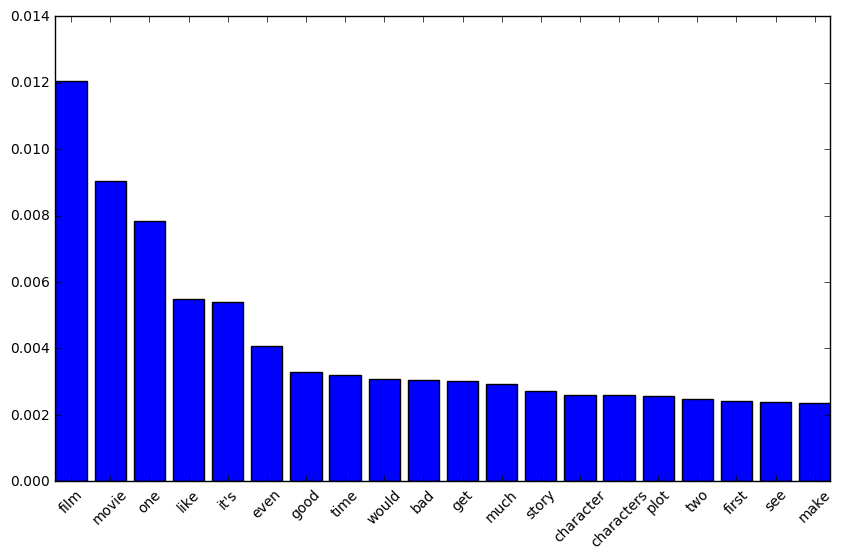

In [12]:
plot_top_k(alpha,'neg',k=20)

See words that 
* indicate positive movie reviews ("good", "like"), 
* are generally likely ("movie", "story")

How about negative reviews?

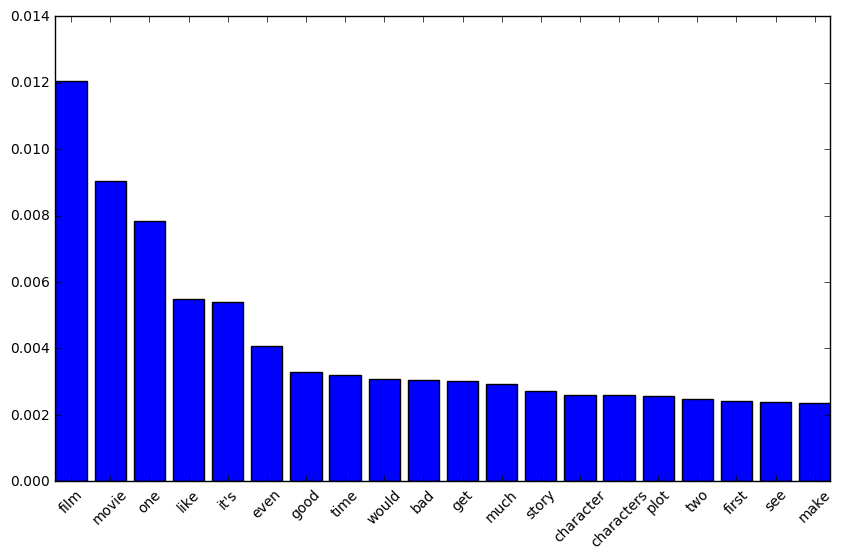

In [13]:
plot_top_k(alpha,'neg', 20)

### Observations
* Negative reviews fairly similar
* Mention "good" just as often as the positive reviews
* Subtle differences: 
    * Negative reviews contain "movie" more than positive ones
    * For "film" this effect is reversed

* "bad" appears with high probability only in the negative reviews

"good" in negative reviews?

In [14]:
def show_context(word, label="neg", index=0, window=5):   
    docs_with_word = [x for x,y in train if word in x and y==label]
    word_index = docs_with_word[index].index(word)
    return docs_with_word[index][max(word_index-window,0):min(word_index+window,len(docs_with_word[index]))]

In [15]:
show_context("good", "neg", 5, 7)

['business',
 'proposition',
 '"',
 'which',
 'i',
 'felt',
 'was',
 'good',
 '.',
 'at',
 'least',
 'the',
 'film',
 "wasn't"]

Looking at the most likely words not that helpful:

* Discriminative words may be rare
* Look at probability *ratios* or *differences*, e.g. $p(\text{bad}\bar +) - p(\text{bad}\bar -)$ 

In [16]:
def diff(alpha, w):
    return alpha[w,'pos'] - alpha[w,'neg'] 

def plot_discriminative_features(alpha, threshold = 0.0001, reverse=False):
    frequent_words = {w for ((w,y),p) in alpha.items() if p > 0.0001}
    sorted_by_ratio = sorted(frequent_words, key=lambda w: diff(alpha, w),reverse=reverse)[-20:]
    util.plot_bar_graph([diff(alpha,w) for w in sorted_by_ratio],sorted_by_ratio,rotation=45)

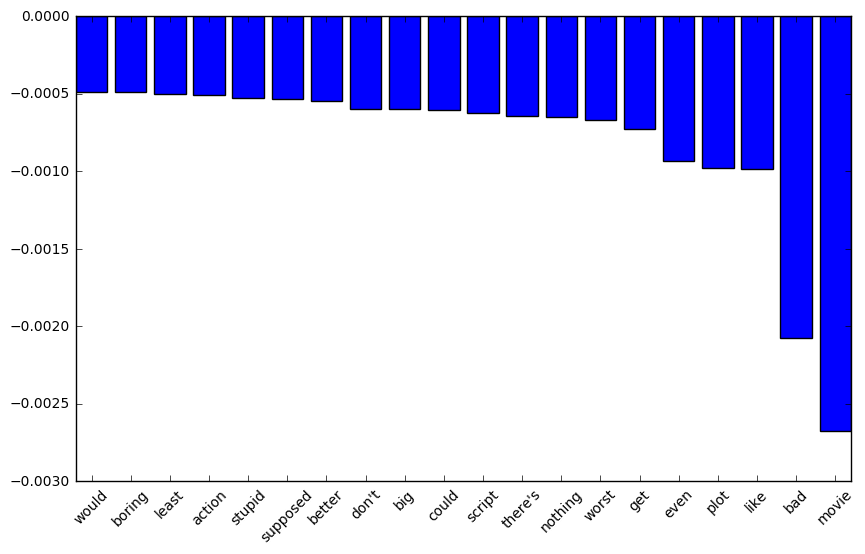

In [17]:
plot_discriminative_features(alpha,reverse=True)

Many of these words seem to match our intuition for negative reviews.

###  Naive Bayes Prediction
Given a trained NB model, how do we predict the class of a given text? 

Like in [MT](word_mt.ipynb) and [parsing](word_mt.ipynb), search for the $y\in\Ys$ with maximum *a posteriori* probability:

$$
\argmax_{y\in\Ys} \prob_\params(y|\x) =  \argmax_{y\in\Ys} \frac{\prob(\x|y) \prob(y) }{ \prob(\x) } = \argmax_{y\in\Ys} \prob(\x|y) \prob(y) 
$$

What to do with words outside of the training vocabulary? 
* Ignore them, assuming that unseen words are equally likely in both classes

In [18]:
from math import log, exp
def log_prob_nb(theta, x, y):
    """
    Calculates the log probability log(p_theta(x|y)).
    """
    alpha, beta = theta
    result = util.safe_log(beta[y])
    for w in x:
        if (w,y) in alpha:
            result += util.safe_log(alpha[w,y])
    return result

In [19]:
def predict_nb(theta, x):
    """
    Finds y^*=argmax_y p_theta(y|x)
    """
    if log_prob_nb(theta, x, 'pos') > log_prob_nb(theta, x, 'neg'):
        return 'pos'
    else:
        return 'neg'

i = 0
predict_nb(theta_filtered,train_filtered[i][0]), train_filtered[i][1]

('neg', 'neg')

## Evaluation
Use **accuracy**, the ratio of the 

* number of correct predictions and the 
* number of all predictions  

$\y^*$ is predicted sequence of labels, $\y$ the true labels:

$$
\mathrm{Acc}(y_1,\ldots,y_n, y^*_1,\ldots,y^*_n, ) = \frac{\sum_i \indi [ y_i = y^*_i]}{n}
$$

In [20]:
def accuracy(data, guess):
    correct = 0
    for (x,y),y_guess in zip(data,guess):
        if y_guess == y:
            correct += 1
    return correct / len(data)

def batch_predict_nb(theta, data):
    return [predict_nb(theta, x) for x,_ in data]

def accuracy_nb(theta,data):
    return accuracy(data, batch_predict_nb(theta,data))

In [54]:
theta_filtered = (alpha, beta) = train_nb(train_filtered,pseudo_count=1.0)
accuracy_nb(theta_filtered, train_filtered), \
accuracy_nb(theta_filtered, dev_filtered)  

(0.9875, 0.825)

## Broken Assumptions

Naive Bayes assumption can make sense, e.g.

$\prob(\text{... great ... awesome}\bar +) \approx \ldots \prob(\text{great}\bar +) \ldots \prob(\text{awesome}\bar +) \ldots$


When is it violated?

What is $p(\text{Fiction}\bar \text{Pulp},+)$ according to NB?

* $\approx 1$
* $p(\text{Fiction}\bar+)$
* $p(\text{Fiction})$

---------------------------
|$\x$                 |$y$| 
|---------------------|---|
|... Pulp Fiction ... | + |
|... Pulp Fiction ... | + |
|... Pulp Fiction ... | + |
|... Fiction ...      | - |
|... Fiction ...      | - |
|... Pulp Fiction ... | - |

What is $p(\text{Fiction}\bar \text{Pulp},+)$ according to this **data**?

$\approx 1$

Therefore NB will **underestimate** 
$$
p(\text{Pulp Fiction}\bar +)
$$ 

which should roughly be

$$
p(\text{Pulp}\bar+)
$$

but is 
$$
p(\text{Pulp}\bar +)p(\text{Fiction}\bar +)
$$

This means a positive instance with "Pulp Fiction" may be **misclassified**

## Bigram Representation

Problem can be partially addressed by using a **bag of bigrams**

* Count bigrams (like Pulp Fiction) and not just single words


Turn

* a, bad, movie

into

* (a,bad),(bad,movie)


In [22]:
def bigram_dataset(data):
    return [([tuple(x[i:i+2]) for i in range(0,len(x)-1)],y) for x,y in data]

train_bigram = bigram_dataset(train_filtered)
dev_bigram = bigram_dataset(dev_filtered)
test_bigram = bigram_dataset(test_filtered)
train_bigram[0][0][:10]

[('dr', 'dolittle'),
 ('dolittle', '20th'),
 ('20th', 'century'),
 ('century', 'fox'),
 ('fox', 'running'),
 ('running', 'time'),
 ('time', '1'),
 ('1', 'hour'),
 ('hour', '25'),
 ('25', 'minutes')]

In [60]:
theta_bigram = (alpha_bigram, beta_bigram) = train_nb(train_bigram, 2.0)
accuracy_nb(theta_bigram, dev_bigram) 

0.82

Look at features

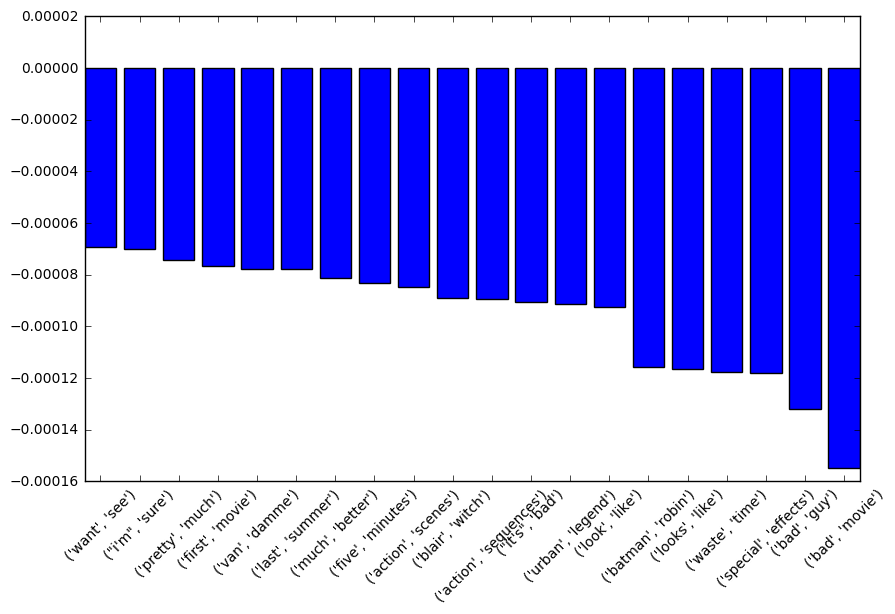

In [24]:
plot_discriminative_features(alpha_bigram, reverse=True)

Observe:

* Presence of entities such as movies and actors

For example
* Mentions of "pulp fiction" suggest positive reviews

How do such reviews look like?

In [25]:
docs_with_good = [x for x,y in train if 'pulp' in x and 'fiction' in x and y=='pos']
for doc_index in range(0,14):
    good_index = docs_with_good[doc_index].index("pulp")
    print(" ".join(docs_with_good[doc_index][good_index-10:good_index+10]))

mode , shine jumps around in time , ala " pulp fiction " . this narrative device works well ;
but if most of those movies have their roots in pulp fiction , exploring a modern myth of the doomed
knack for giving his stars big careers . after his pulp fiction , many actors began receiving many offers for

dogs has hints of the tarantino brilliance that emerged in pulp fiction , but is a much less substantive ,
take the review and turn it into a comparison of pulp fiction , just because quentin tarantino directed and wrote
, it was citizen kane , with arthouse it was pulp fiction , and with comedy it was , well
an oscar nomination ? all for his sophomore outing , pulp fiction . since then , the talented film maker
first movie quentin tarantino has directed since the highly touted pulp fiction . to say he has been inactive in
this statement , but you need look no further than pulp fiction for an example ) . and , while
the three years since the release of the groundbreaking success pulp f

Still problems, like longer distance dependencies: 

$$
p(\text{Quentin} \bar \text{Pulp},+)
$$

Can we do more with unigrams?

Let $\hat{\prob}$ be the empirical distribution

The problem is: $\pnb(\text{Pulp Fiction}\bar +)$ is **too small**  

\begin{split}
\pnb(\text{Pulp Fiction}\bar +) &= \pnb(\text{Pulp}\bar +)\pnb(\text{Fiction} \bar +) \\\\
                                &\approx \hat{\prob}(\text{Pulp}\bar +) \hat{\prob}(\text{Fiction} \bar +) \\\\
                                & < \hat{\prob}(\text{Pulp}\bar +) \hat{\prob}(\text{Fiction}\bar \Pulp, +) \\\\
                                &\approx \hat{\prob}(\text{Pulp}\bar +) \\\\
\end{split}

How to fix this for a unigram model?

* Increase $\prob(\text{Pulp}\bar +)$ 

If 

$$
\pnb(\text{Pulp}\bar +)\approx \frac{\hat{\prob}(\text{Pulp}\bar +)}{\hat{\prob}(\text{Fiction}\bar +)}
$$ 

we'd get

\begin{split}
\pnb(\text{Pulp Fiction}\bar +) & \approx \frac{\hat{\prob}(\text{Pulp}\bar +)}{\hat{\prob}(\text{Fiction}\bar +)} \hat{\prob}(\text{Fiction}\bar +)  \\\\ & = \hat{\prob}(\text{Pulp}\bar +)
\end{split}

Note: $\pnb(\text{Pulp}\bar +)$ may be **larger than 1**

But this is **not the maximum likelhood estimate**...

If you were to generate data from it, it could look like

---------------------------
|$\x$                 |$y$| 
|---------------------|---|
|... Pulp Pulp ... | + |
|... Pulp Pulp ... | + |
|... Pulp Fiction ... | + |
|... Fiction ...      | - |
|... Fiction ...      | - |
|... Pulp Pulp ... | - |

But it **doesn't matter** for us, because we get

$$
\prob(+ \bar \text{...Pulp Fiction...}) = \frac{\prob(+ , \text{...Pulp Fiction...})}{\prob(+, \text{...Pulp Fiction...}) + \prob(- , \text{...Pulp Fiction...})} < \frac{1}{2}
$$

right

## Discriminative Text Classification

Ignore generation, care about **discrimination**

(Make war, not love)

How can we set probabilities algorithmically?

Turn it into an optimisation problem and 

maximise $\prob(+ \bar \text{...Pulp Fiction...})$ directly

### Maximum Conditional Log-Likelihood

Directly optimise the **conditional likelihood** of the correct labels

$$
\mathit{CL}(\params) = \sum_{(\x,y) \in \train} \log(\prob_\params(y|\x)) = \sum_{(\x,y) \in \train} \log\left(\frac{\prob_\params(y,\x)}{\sum_y \prob_\params(y,\x)}\right)
$$

Unfortunately less trivial to optimise (no closed form solution), more on that later...

## Log-Linear Models
Present NB (and other following models) in log-space:
* Simplify math 
* easier to optimise
* enables rich generalisations
* resemblance to linear models like linear SVMs... 

\begin{split}
p^{\text{NB}}_{\params}(\PulpFiction \, \Fiction,+) = & \exp \left( \log(\pnb(\Pulp \bar +) \right) \exp \left( \log(\pnb(\Fiction \bar +) \right) \\\\ & \exp \left( \log(\pnb(\Fiction \bar +) \right) \exp \left( \log(\pnb( +) \right) \\\\
\end{split}

\begin{split}
p^{\text{NB}}_{\weights}(\PulpFiction \, \Fiction,+)  & = \exp \left( w_{\Pulp,+} \right) \exp \left( w_{\Fiction,+} \right) \exp \left( w_{\Fiction,+} \right) \exp \left( w_{+} \right) \\\\
& = \exp \left( 1 \cdot w_{\Pulp,+} + 2 \cdot w_{\Fiction,+} + 1 \cdot w_{+} \right) \\\\
& = \exp \left( f_{\Pulp}(\x) \cdot w_{\Pulp} + f_{\Fiction}(\x) \cdot w_{\Fiction,+} + f_{0}(\x) \cdot w_{+} \right) \\\\
\end{split}

$$
p^{\text{NB}}_{\weights}(\PulpFiction \, \Fiction,+) = \exp \langle \mathbf{f}(\x), \mathbf{w}_y \rangle 
$$

with 

$$
\mathbf{f}(\x) = \begin{bmatrix} f_{\Pulp}(\x) \\ f_{\Fiction}(\x) \\ f_{0}(\x) \end{bmatrix}
$$

and

$$
\mathbf{w}_y = \begin{bmatrix} w_{\Pulp,+} \\ w_{\Fiction,+} \\ w_{+} \end{bmatrix}
$$


In practice, vector defined for **all words**:

$$
\mathbf{f}(\x) = \begin{bmatrix} f_{\text{movie}}(\x)\\ \ldots \\ f_{\Pulp}(\x) \\ f_{\Fiction}(\x) \\ \ldots \\ f_{0}(\x) \end{bmatrix}
$$


### Feature Functions 
$f_i$ are so called *feature functions*
* $i\in \mathcal{I}$ with:
    * index 0: index of *bias* feature 
    * index $x'$: index of count of word $x'$ feature:

\begin{split}
  f_{0}(\x) & = 1  \\\\
  f_{x'}(\x) & = \sum_i^{\text{length}(\x)} \delta(x',x_i) 
\end{split}

More generally:   

\begin{equation}
  p^{\text{NB}}_{\weights}(\x,y)= \exp \left( \sum_{i \in \mathcal{I}} f_i(x) w_{y,i} \right) = \exp \langle \mathbf{f}(\x), \mathbf{w}_y \rangle = \exp s_\weights(\x,y)
\end{equation}

where $s_\weights(\x,y) = \langle \mathbf{f}(\x), \mathbf{w}_y \rangle$ is the linear **score** of $(\x,y)$

(No normalisation if weights are apropriately chosen)

Set weights according to

\begin{split}
  w_{y'} & = \log \beta_{y'}\\\\
  w_{x',y'} & = \log \alpha_{x',y'}
\end{split}

to get original NB model. 


### Conditional Distributions

We care about conditional probabilities: 
\begin{equation}
  p^{\text{NB}}_{\params}(y|\x)= \frac{1}{Z_\x} \exp \langle \mathbf{f}(\x), \mathbf{w}_y \rangle = \frac{1}{Z_\x} \exp s_\weights(\x,y)
\end{equation}

with normalizer ("partition function"): 

$$
Z_\x=\sum_{y\in\Ys} \exp s_\weights(\x,y)
$$ 



Note: **weights do not need to normalise**

For binary tasks corresponds to **logistic regression model**:

$$
\frac{1}{Z_\x} \exp s_\weights(\x,y) = \frac{\exp s_\weights(\x,y)}{\exp s_\weights(\x,+)+\exp s_\weights(\x,-)} = \operatorname{sigmoid}\left(s_\weights(\x,y)\right)  
$$

Conditional log-likelihood in log-linear form:

$$
\mathit{CL}(\weights) = \sum_{(\x,y) \in \train} \log \left (\frac{1}{Z_\x} \exp s_\weights(\x,y) \right) = \sum_{(\x,y) \in \train} s_\weights(\x,y) - \log Z_\x.
$$

In [26]:
p,f = "Pulp", "Fiction"
data = [((p,f),True),((p,f),True),((p,f),True), ((f,),False), ((f,),False),((p,f),False)]
from math import log, exp

def cl(data, w_p_true, w_f_true, w_true, l=0.0):
    loss = 0.0
    for x,y in data:
        count_p = len([w for w in x if w==p])
        count_f = len([w for w in x if w==f])
        score_true = w_true + count_p * w_p_true + count_f * w_f_true
        log_z = log(exp(score_true) + exp(0))
#         print(count_p)
#         print(count_f)
#         print(log_z)
        if y:
            loss += score_true - log_z
        else:
            loss += 0 - log_z
    return loss - l * (w_p_true * w_p_true + w_f_true * w_f_true + w_true * w_true)

def jl(data, w_p_true, w_f_true, w_true, w_p_false, w_f_false, w_false):
    loss = 0.0
    for x,y in data:
        count_p = len([w for w in x if w==p])
        count_f = len([w for w in x if w==f])
        score_true = w_true + count_p * w_p_true + count_f * w_f_true
        score_false = w_false + count_p * w_p_false + count_f * w_f_false
        if y:
            loss += score_true
        else:
            loss += score_false
    return loss 


# cl(data,log(0.5),log(0.5),log(0.5))

import matplotlib.pyplot as plt
import mpld3
import numpy as np

# x = np.linspace(-10, 10, 100)
# cl_loss = np.vectorize(lambda w: cl(data,w,log(0.5),log(0.5),1))

Consider loss on this data:

In [27]:
import pandas as pd
pd.DataFrame(data, columns = ["x","y"])

/usr/local/lib/python3.5/site-packages/pandas/__init__.py:7: DeprecationWarning: bad escape \s
  from pandas import hashtable, tslib, lib


,x,y
0,"(Pulp, Fiction)",True
1,"(Pulp, Fiction)",True
2,"(Pulp, Fiction)",True
3,"(Fiction,)",False
4,"(Fiction,)",False
5,"(Pulp, Fiction)",False


Set $w_{\Fiction,+}=w_{+}=\log 0.5$, vary $w_{\Pulp,+}=\log(\prob(\Pulp \bar +))$

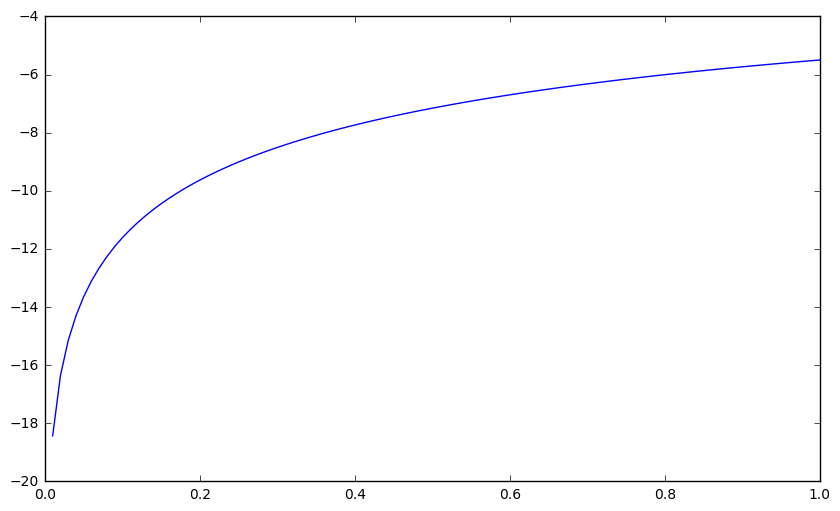

In [28]:
x = np.linspace(0.01, 1.0, 100)
cl_loss = np.vectorize(lambda p: cl(data,log(p),log(0.5),log(0.5)))
y = cl_loss(x)
plt.plot(x, y)

Compare to [exercise 1 solutions](http://localhost:8888/notebooks/exercises/structured_prediction_solutions.ipynb)

Compare to the **joint likelihood** we optimised before:
   
$$
\sum_{(\x,y) \in \train} \log(\prob_\params(y,\x))
$$

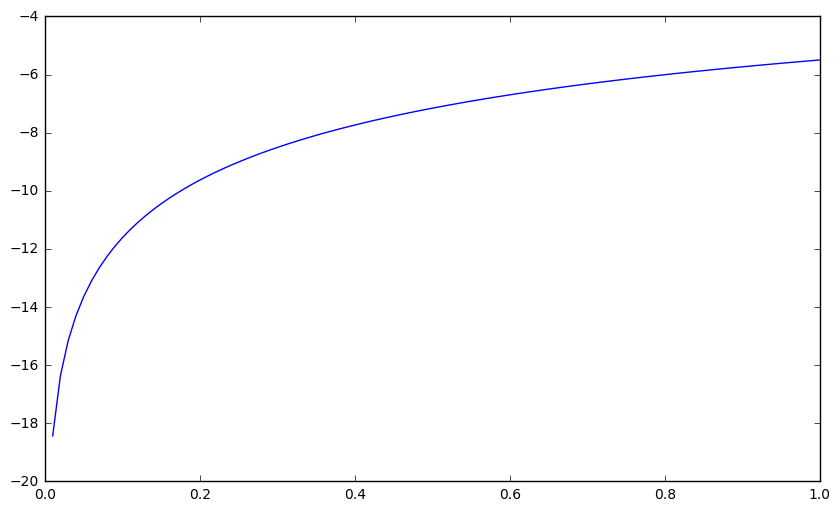

In [29]:
x = np.linspace(0.01, 0.999, 100)
jl_loss = np.vectorize(lambda p: jl(data,log(p),log(1-p),log(0.5),
                                    log(1/4),log(3/4),log(0.5)))
y = cl_loss(x) # CHANGE to jl
plt.plot(x, y)

### Other Objectives
Other structured prediction losses replace $\log Z_\x$ with other terms:

$$
\mathit{PERCEPTRON}(\weights) = \sum_{(\x,y) \in \train} s_\weights(\x,y) - s_\weights(\x,y^*(\x))
$$

where $y^*(\x)=\argmax_{y\in\Ys} s_\weights(\x,y)$ 

Aka **structured perceptron** loss!

## Regularisation
Estimating a log-linear models can lead to *overfitting*

* For example, reviews of movies may often contain the **name** of the movie to reviewed.
* False *killer feature*: only appears in one training instance 
* weight can be set in way that we get perfect accuracy on this instance 

*regularise* the model by **penalising** large weights:

* add a regularisation penalty to the training objective
* For example,  $||\weights||_2$ and $||\weights||_1$, the L2 and L1 norm of the weight vector

$$
\mathit{RCL}(\weights) = \sum_{(\x,y) \in \train} \log(\prob_\weights(y|\x)) - \frac{1}{C} ||\weights||_2
$$

$C$ controls inverse strength of regularisation

Both L1 and L2 have their strength and weaknesses. 
* L1 regularisation can lead to sparse vectors with zero weights, and this can improve the memory footprint of your model. 
* L2 seems to often lead to [better results](http://www.csie.ntu.edu.tw/~cjlin/liblinear/FAQ.html#l1_regularized_classification). 

Vary regularisation:

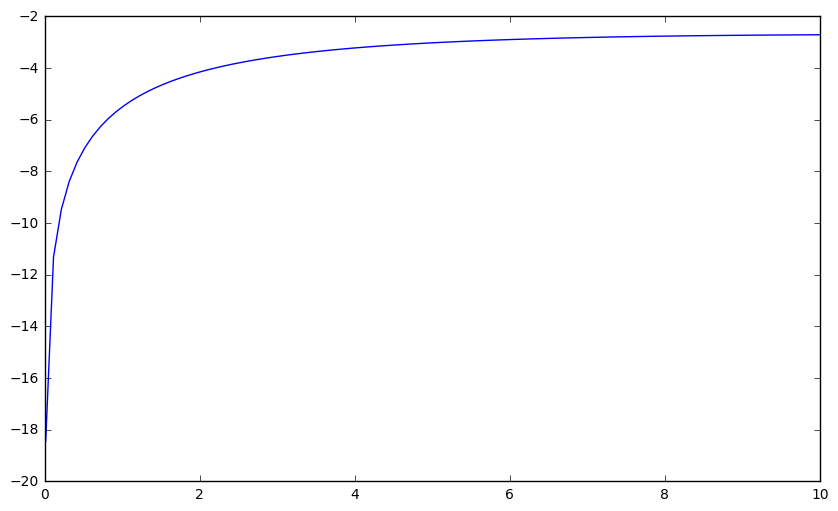

In [30]:
x = np.linspace(0.01, 10.0, 100)
C = 10000.0
cl_loss = np.vectorize(lambda p: cl(data,log(p),log(0.5),log(0.5),1/C))
y = cl_loss(x)
plt.plot(x, y)

Can be understood as maximum-a-posteriori inference of the parameters under [specific priors](http://www.stat.columbia.edu/~gelman/research/published/priors11.pdf)

For example, L2 regularisation assumes a Gaussian prior.  

## Optimising the Conditional Loglikelihood
No closed form solution, use **iterative methods** such as 

* L-BFGS
* Stochastic Gradient Descent

"Easy" because **concave** in weights $\weights$

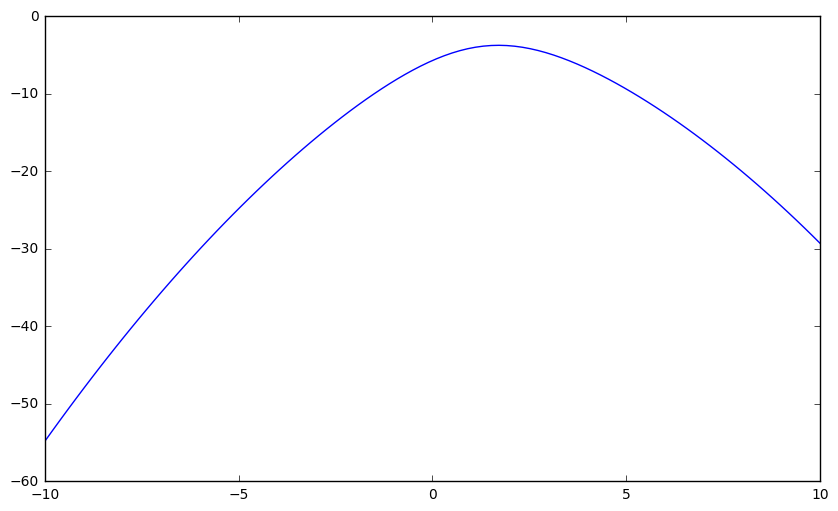

In [31]:
x = np.linspace(-10, 10, 100)
C = 5.0
cl_loss = np.vectorize(lambda w: cl(data,w,log(0.5),log(0.5),1/C))
y = cl_loss(x)
plt.plot(x, y)

Can we characterise the optimum?

In [32]:
def prob_log_reg(x, w_p_true,  w_f_true, w_true):
    count_p = len([w for w in x if w==p])
    count_f = len([w for w in x if w==f])
    score_true = w_true + count_p * w_p_true + count_f * w_f_true
    log_z = log(exp(score_true) + exp(0))
    return exp(score_true - log_z)

def indi(pred, value=1.0):
    return value if pred else 0.0

def expectations(data, w_p_true,  w_f_true, w_true):   
    data_probs = [(x,
                   indi(y),
                   prob_log_reg(x,w_p_true,w_f_true,w_true),
                   indi(p in x and y),
                   indi(p in x, prob_log_reg(x,w_p_true,w_f_true,w_true)),
                   indi(f in x and y),
                   indi(f in x, prob_log_reg(x,w_p_true,w_f_true,w_true)),
                   cl([(x,y)],w_p_true,w_f_true,w_true)) 
                  for x,y in data]
    last_row = [('[Avg]',
                 sum(data[1] for data in data_probs)/6,
                 sum(data[2] for data in data_probs)/6,
                 sum(data[3] for data in data_probs)/6,
                 sum(data[4] for data in data_probs)/6,
                 sum(data[5] for data in data_probs)/6,
                 sum(data[6] for data in data_probs)/6,
                 sum(data[7] for data in data_probs)/6
                )]
    return pd.DataFrame(data_probs + last_row, columns = ['x','y','p(+)','#(Pulp)p_data(+)','#(Pulp)p(+)', 
                                                          '#(Fiction)p_data(+)','#(Fiction)p(+)','CL'])
    

In [33]:
expectations(data, 0, 0, 0) 

,x,y,p(+),#(Pulp)p_data(+),#(Pulp)p(+),#(Fiction)p_data(+),#(Fiction)p(+),CL
0,"(Pulp, Fiction)",1.0,0.5,1.0,0.500000,1.0,0.5,-0.693147
1,"(Pulp, Fiction)",1.0,0.5,1.0,0.500000,1.0,0.5,-0.693147
2,"(Pulp, Fiction)",1.0,0.5,1.0,0.500000,1.0,0.5,-0.693147
3,"(Fiction,)",0.0,0.5,0.0,0.000000,0.0,0.5,-0.693147
4,"(Fiction,)",0.0,0.5,0.0,0.000000,0.0,0.5,-0.693147
5,"(Pulp, Fiction)",0.0,0.5,0.0,0.500000,0.0,0.5,-0.693147
6,[Avg],0.5,0.5,0.5,0.333333,0.5,0.5,-0.693147


### Expectations Match: Why? 

Let's look at the $\mathit{CL}$ gradient:

\begin{split}
  \nabla_{\weights_{y'}} CL(\params) =  \sum_{(\x,y) \in \train} \mathbf{f}(\x) \delta(y,y') - p_\params(y'|\x) \mathbf{f}(\x) = \sum_{(\x,y) \in \train} \mathbf{f}(\x) \delta(y,y') - \sum_{(\x,y) \in \train} p_\params(y'|\x) \mathbf{f}(\x).
\end{split}

Solution $\weights*$ when this gradient is zero:

* **empirical** expectations $\sum_{(\x,y) \in \train} \mathbf{f}(\x) \delta(y,y')$ for class $y'$ 

match 

* **model** expectations $\sum_{(\x,y) \in \train} p_\params(y'|\x) \mathbf{f}(\x)$

Compare to dual "Maximum Entropy" formulation 

### How to Find Optimum?

In practice one of the following:
* You have to implement both optimisation code and gradient calculation
* You have an off-the-shelf gradient descent library, you provide the gradients (Example: [factorie](http://factorie.cs.umass.edu/))
* You have a back-propagation framework (such as Tensorflow) 
* You have a library (such as scikit-learn) for a specific model class 

Here: scikit-learn 


## Logistic Regression Toolkits
A log-linear model trained by maximising the CL corresponds to training a **logistic regression** model

[logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) implementation of [scikit-learn](http://scikit-learn.org/stable/index.html)

Convert $\x \in \Xs$ to a (sparse) feature vector $\mathbf{f}(\x)$:

In [34]:
def to_dict(x):
    result = defaultdict(float)
    for w in x:
        result[w] += 1.0
    return result

to_dict(['pulp','fiction','fiction'])

defaultdict(float, {'fiction': 2.0, 'pulp': 1.0})

Apply to training and test instances:

In [35]:
from collections import defaultdict
from sklearn.feature_extraction import DictVectorizer
vectorizer = DictVectorizer()

train_X = vectorizer.fit_transform([to_dict(x) for x,_ in train_filtered])
dev_X = vectorizer.transform([to_dict(x) for x,_ in dev_filtered])
dev_X[0]

/usr/local/lib/python3.5/site-packages/scipy/_lib/decorator.py:205: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  first = inspect.getargspec(caller)[0][0]  # first arg


<1x45862 sparse matrix of type '<class 'numpy.float64'>'
	with 123 stored elements in Compressed Sparse Row format>

scikit-learn wants prefers numbers as classes:

* $\text{positive}\rightarrow 0$
* $\text{negative}\rightarrow 1$

In [36]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_Y = label_encoder.fit_transform([y for _,y in train_filtered])
dev_Y = label_encoder.transform([y for _,y in dev_filtered])

dev_Y[:10]

array([1, 1, 0, 0, 0, 1, 0, 0, 1, 1])

Train the logistic regression with l2 regularisation at $C=8.0$

In [37]:
from sklearn.linear_model import LogisticRegression
import numpy as np

lr = LogisticRegression(C=8.0)
lr.fit(train_X, train_Y)

/usr/local/lib/python3.5/site-packages/scipy/_lib/decorator.py:205: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  first = inspect.getargspec(caller)[0][0]  # first arg


LogisticRegression(C=8.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Weights learned:
* single weight vector $\weights=\weights_\text{positive} - \weights_\text{negative}$

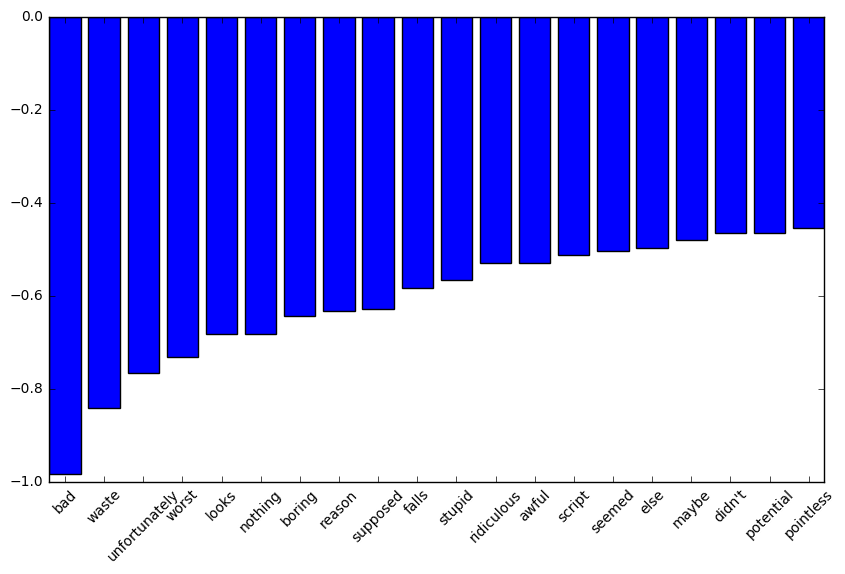

In [38]:
weights = vectorizer.inverse_transform(lr.coef_)[0]
sorted_weights = sorted(weights.items(), key=lambda t: t[1])
util.plot_bar_graph([w for _,w in sorted_weights[:20]],
                    [f for f,_ in sorted_weights[:20]],rotation=45)

More obvious **discriminative** features for the negative class 

* Conditional log-likelihood down-weighs a feature $f_i$ for $y=-$ 
    * if $f_i$ is active in $\x$
    * but gold label is $y=+$



Positive weights? 

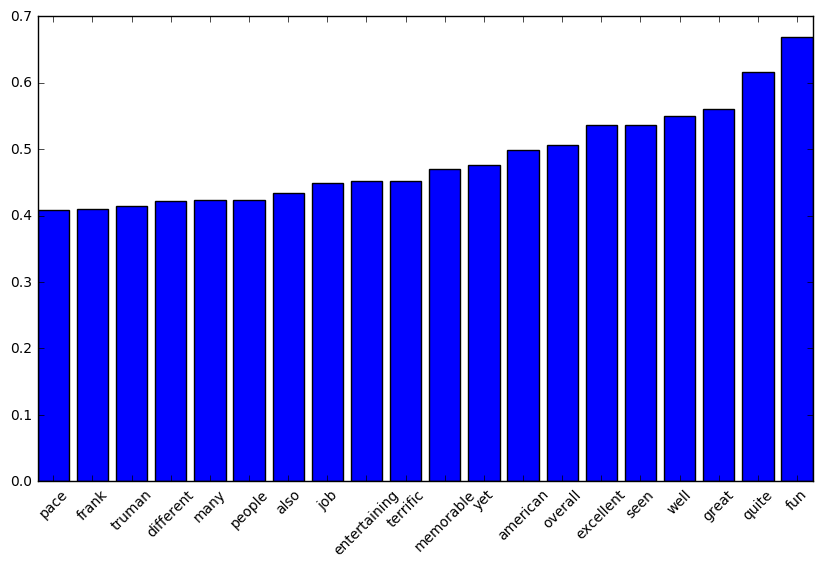

In [39]:
util.plot_bar_graph([w for _,w in sorted_weights[-20:]],
                    [f for f,_ in sorted_weights[-20:]],rotation=45)

Discriminative training helps! 

(Compare 0.80 with unigram model before)

In [40]:
lr_guess = label_encoder.inverse_transform(lr.predict(dev_X))
accuracy(dev_filtered, lr_guess)

0.835

## Summary

* NB Bayes effective text classifier
* Makes independence assumptions that can be violated
* Compensate with more complex models or
* Training **discriminatively**
* Increase relative/conditional probability of classes, not joint probability

## Background Material
* [Tackling the Poor Assumptions of Naive Bayes Text Classifiers](https://people.csail.mit.edu/jrennie/papers/icml03-nb.pdf), Rennie et al, ICML 2003 
* [Simple Sentiment Classification](http://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf), Sida Wang and Christopher D. Manning, ACL 2012 